<a href="https://colab.research.google.com/github/jayrodge/AudioMNIST-using-PyTorch/blob/master/AudioClassifierMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!git clone https://github.com/jayrodge/AudioMNIST-using-PyTorch.git

Cloning into 'AudioMNIST-using-PyTorch'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 60131 (delta 0), reused 0 (delta 0), pack-reused 60128
Receiving objects: 100% (60131/60131), 1.40 GiB | 15.44 MiB/s, done.
Resolving deltas: 100% (3/3), done.
Checking out files: 100% (60005/60005), done.


In [0]:
import os 
os.chdir('AudioMNIST-using-PyTorch/')

In [0]:
for i in tqdm(sorted(os.listdir('Spectogram/'))):
  for j in sorted(os.listdir('Spectogram/'+i)):
    
    command = 'cp '+'Spectogram/'+str(i)+'/'+j+' MNIST/0'+str(j[0])+'/.'
    os.system(command)
#     print(command)

100%|██████████| 60/60 [03:45<00:00,  3.84s/it]


## Importing Packages

In [0]:
import torch
import numpy as np
from tqdm import tqdm
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [0]:
# how many samples per batch to load
batch_size = 32
# percentage of training set to use as validation
test_size = 0.3
valid_size = 0.1

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [0]:
train_data = datasets.ImageFolder('MNIST/',transform=transform)

## Splitting the Data into Train, Test and Validation

In [0]:
#For Test Set
num_data = len(train_data)
indices_data = list(range(num_data))
np.random.shuffle(indices_data)
split_tt = int(np.floor(test_size * num_data))
train_idx, test_idx = indices_data[split_tt:], indices_data[:split_tt]

# For Valid Set
num_train = len(train_idx)
indices_train = train_idx
np.random.shuffle(indices_train)
split_tv = int(np.floor(valid_size * num_train))
train_new_idx, valid_idx = indices_train[split_tv:],indices_train[:split_tv]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_new_idx)
test_sampler = SubsetRandomSampler(test_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [0]:
# confirming the train-test-valid split is legit
len(set(train_new_idx) | set(test_idx) | set(valid_idx))

30000

In [0]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,sampler=train_sampler, num_workers=2)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=2)
test_loader = torch.utils.data.DataLoader(train_data, sampler = test_sampler, batch_size=batch_size, num_workers=2)
classes = [i for i in range(10)]

## Visualizing subset of Data

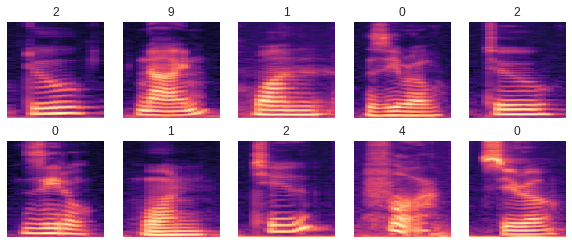

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(10, 4))
# display 20 images
for idx in np.arange(10):
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

## Initializing CNN Model

In [0]:
import torch.nn as nn
import torch.nn.functional as F
train_on_gpu = torch.cuda.is_available()
# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer
        self.conv1 = nn.Conv2d(3, 16, 5)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(32*53*53, 256)
        self.fc2 = nn.Linear(256, 84)
        self.fc3 = nn.Linear(84, 10)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
#         x = self.dropout(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(-1, 32 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.softmax(self.fc3(x))
        return x

# create a complete CNN
model = Net()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (dropout): Dropout(p=0.2)
  (fc1): Linear(in_features=89888, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (softmax): LogSoftmax()
)


## Loading the Model from the Checkpoint (If needed)

In [0]:
# Loading saved model
# model.load_state_dict(torch.load('model_cifar.pt'))

## Initialising Loss function and Optimizer

In [0]:
import torch.optim as optim

# loss function
criterion = torch.nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, momentum= 0.9)

## Training the CNN Model

In [0]:
# number of epochs to train the model
n_epochs = 5 # you may increase this number to train a final model

valid_loss_min = np.Inf # track change in validation loss

for epoch in tqdm(range(1, n_epochs+1)):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    

    # train the model 
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        

    # validate the model 
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_MNIST.pt')
        valid_loss_min = valid_loss

 20%|██        | 1/5 [08:27<33:48, 507.22s/it]

Epoch: 1 	Training Loss: 0.384534 	Validation Loss: 0.004153
Validation loss decreased (inf --> 0.004153).  Saving model ...


 40%|████      | 2/5 [16:53<25:20, 506.79s/it]

Epoch: 2 	Training Loss: 0.047545 	Validation Loss: 0.002730
Validation loss decreased (0.004153 --> 0.002730).  Saving model ...


 60%|██████    | 3/5 [25:24<16:56, 508.16s/it]

Epoch: 3 	Training Loss: 0.032239 	Validation Loss: 0.000876
Validation loss decreased (0.002730 --> 0.000876).  Saving model ...


 80%|████████  | 4/5 [34:06<08:32, 512.37s/it]

Epoch: 4 	Training Loss: 0.022165 	Validation Loss: 0.000957


100%|██████████| 5/5 [42:56<00:00, 517.60s/it]

Epoch: 5 	Training Loss: 0.016135 	Validation Loss: 0.000610
Validation loss decreased (0.000876 --> 0.000610).  Saving model ...


## Testing the CNN Model

In [0]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
i=1
# iterate over test data
len(test_loader)
for data, target in test_loader:
    i=i+1
    if len(target)!=batch_size:
        print(i)
        continue
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    
    for i in range(batch_size):       
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

32
Test Loss: 0.006979

Test Accuracy of     0: 99% (864/869)
Test Accuracy of     1: 97% (872/897)
Test Accuracy of     2: 99% (880/888)
Test Accuracy of     3: 99% (892/895)
Test Accuracy of     4: 99% (916/921)
Test Accuracy of     5: 99% (918/923)
Test Accuracy of     6: 99% (916/922)
Test Accuracy of     7: 99% (907/913)
Test Accuracy of     8: 99% (881/886)
Test Accuracy of     9: 99% (876/878)

Test Accuracy (Overall): 99% (8922/8992)
